# Package 

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pickle
with open('/content/drive/My Drive/wizsolution/ProjectA/preprocessed_data_full.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
data.keys()

dict_keys(['x_train', 'y_train', 'x_test', 'y_test', 'le'])

### Some Additional Preprocess

In [6]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'normal.')[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

binary_y_train = convert_label_to_binary(data['le'], data['y_train'])
binary_y_test = convert_label_to_binary(data['le'], data['y_test'])

# check how many anomalies are in our labels
print('Number of anomalies in y_train: ', binary_y_train.sum())
print('Number of anomalies in y_test:  ', binary_y_test.sum())


Number of anomalies in y_train:  7261
Number of anomalies in y_test:   2466


In [0]:
dtrain = xgb.DMatrix(data['x_train'], label=binary_y_train)
dtest = xgb.DMatrix(data['x_test'], label=binary_y_test)

# Random Params Search

### Params Base Case and Search Grid

In [0]:
params_base = {
    # Tuning Params
    'num_rounds':        10,
    'max_depth':         8,
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1, 
    'learning_rate':     0.1, 
    'subsample':         1, 
    'reg_lambda':        1, 
    'scale_pos_weight':  2,
    
    # Not Tuning Params
    'tree_method':       'gpu_hist',
    'n_gpus':            1,
    'objective':         'binary:logistic',
    'verbose':           True
}


params_grid_array = {
    'num_rounds':        np.arange(1,20,1),
    'max_depth':         np.arange(3,10,1), # CV 3-10
    'max_leaves':        range(2**7,2**9,2**4),
    'alpha':             np.arange(0,1,0.1),
    'eta':               np.arange(0.01,0.2,0.01), # 0.01-0.2
    'gamma':             np.arange(0,0.5,0.1), 
    'learning_rate':     np.arange(0.05,0.3,0.01), # 0.05 - 0.3 
    'subsample':         np.arange(0.5,1,0.1), # 0.5 - 1
    'reg_lambda':        range(1,6), # control overfitting
    'scale_pos_weight':  range(1,6), # faster converge, imbalance
}
threshold = .5
true_labels = binary_y_test.astype(int)

def ModelTune(params):
  num_rounds = params['num_rounds']
  model = xgb.train(params, dtrain, num_rounds)
  preds = model.predict(dtest)
  pred_labels = (preds >= threshold).astype(int)
  accuracy = accuracy_score(true_labels, pred_labels)
  a = confusion_matrix(true_labels, pred_labels)
  specificity = a[1,0]/a[1,1]
  return accuracy, specificity, a

In [0]:
accuracy_base, specificity_base, conf_matrix_base = ModelTune(params_base)

### Search Through The Grid

In [0]:
def RandomPick(grid):
  variable = list(grid.keys())
  choice = dict.fromkeys(variable)
  for i in variable:
    choice[i] = np.random.choice(grid[i])
  return choice

In [0]:
Trys = dict.fromkeys(list(params_grid_array.keys()),[])
SearchResult = {'accuracy':[], 'specificity':[]}
num = 150
for i in range(num):
  choice = RandomPick(params_grid_array)
  Trys = {key:(Trys[key] + [choice[key]]) for key in Trys}
  params_try = {**params_base, **choice}
  accuracy, specificity,conf_matrix = ModelTune(params_try)
  SearchResult['accuracy'].append(accuracy)
  SearchResult['specificity'].append(specificity)
SearchResult.update(Trys)
Result = pd.DataFrame(SearchResult)
  

In [17]:
Result

,accuracy,specificity,num_rounds,max_depth,max_leaves,alpha,eta,gamma,learning_rate,subsample,reg_lambda,scale_pos_weight
0,0.999963,0.003255,17,6,272,0.9,0.17,0.3,0.18,0.8,1,4
1,0.999943,0.005300,9,7,272,0.0,0.02,0.1,0.11,0.9,2,5
2,0.999923,0.005710,6,7,224,0.2,0.01,0.3,0.12,0.5,5,4
3,0.999915,0.008177,3,4,256,0.9,0.01,0.3,0.15,0.6,2,5
4,0.999634,0.034830,13,3,352,0.2,0.18,0.0,0.07,0.9,1,1
5,0.999935,0.006120,5,7,240,0.5,0.15,0.2,0.06,0.8,3,5
6,0.999866,0.012731,6,3,224,0.3,0.03,0.0,0.25,0.8,1,3
7,0.999963,0.003255,8,9,272,0.0,0.06,0.1,0.19,0.6,1,3
8,0.999935,0.004890,16,5,368,0.7,0.18,0.0,0.11,0.6,2,4
9,0.999963,0.003255,17,7,368,0.5,0.03,0.2,0.15,0.6,5,3


In [14]:
Result = pd.DataFrame(SearchResult)
params_best = Result.iloc[[Result[Result.accuracy >= accuracy_base].specificity.idxmin()]].iloc[:,2:].to_dict('record')[0]
params_best = {**params_base,**params_best}
accuracy_adjust,specificity_adjust,conf_matrix_adjust = ModelTune(params_best)
print('Base Case Accuracy is {}'.format(accuracy_base))
print('Adjusted Case Accuracy is {}'.format(accuracy_adjust))
print('Base Case Specificity is {}'.format(specificity_base))
print('Adjusted Case Specificity is {}'.format(specificity_adjust))

Base Case Accuracy is 0.9999470742222965
Adjusted Case Accuracy is 0.9999674302906439
Base Case Specificity is 0.003663003663003663
Adjusted Case Specificity is 0.0024390243902439024


In [18]:
params_best

{'alpha': 0.2,
 'eta': 0.17,
 'gamma': 0.2,
 'learning_rate': 0.27,
 'max_depth': 7,
 'max_leaves': 224,
 'n_gpus': 1,
 'num_rounds': 18,
 'objective': 'binary:logistic',
 'reg_lambda': 3,
 'scale_pos_weight': 3,
 'subsample': 0.8999999999999999,
 'tree_method': 'gpu_hist',
 'verbose': True}

The Base Case Confusion Matrix


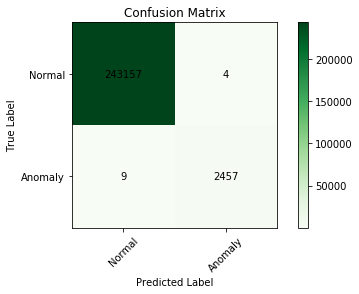

In [15]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

print("The Base Case Confusion Matrix")
plot_confusion_matrix(conf_matrix_base, ['Normal','Anomaly'])

The Confusion Matrix After Tuning


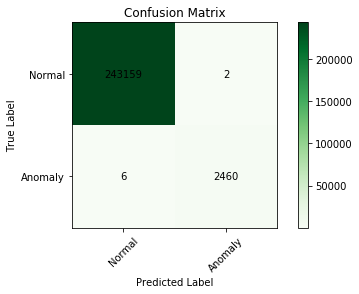

In [16]:
print("The Confusion Matrix After Tuning")
plot_confusion_matrix(conf_matrix_adjust, ['Normal','Anomaly'])